#Importing Dependencies & Dataset:

In [ ]:
!pip install tensorflow tensorflow-gpu matplotlib tensorflow-datasets ipywidgets

In [2]:
# Limiting the GPU utilization so that we prevent out of memory errors
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [4]:
# We will only take the training data from the dataset
ds = tfds.load('celeb_a', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/162770 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/celeb_a/2.0.1.incompleteCU607F/celeb_a-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/19867 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/celeb_a/2.0.1.incompleteCU607F/celeb_a-validation.tfrecord*...:   0%|     …

Generating test examples...:   0%|          | 0/19962 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/celeb_a/2.0.1.incompleteCU607F/celeb_a-test.tfrecord*...:   0%|          |…

Dataset celeb_a downloaded and prepared to /root/tensorflow_datasets/celeb_a/2.0.1. Subsequent calls will reuse this data.


In [5]:
ds.as_numpy_iterator().next().keys()

dict_keys(['attributes', 'image', 'landmarks'])

#Visualizing & Building The Dataset:

In [6]:
import numpy as np

### We want to iterate over the data without putting it all in memory. Therefore, we will create a data iterator. 

In [8]:
data_iterator = ds.as_numpy_iterator()

In [11]:
# We iteratre over the data in samples using "next()"
data_iterator.next()

{'attributes': {'5_o_Clock_Shadow': False,
  'Arched_Eyebrows': False,
  'Attractive': True,
  'Bags_Under_Eyes': False,
  'Bald': False,
  'Bangs': True,
  'Big_Lips': False,
  'Big_Nose': False,
  'Black_Hair': False,
  'Blond_Hair': True,
  'Blurry': False,
  'Brown_Hair': False,
  'Bushy_Eyebrows': False,
  'Chubby': False,
  'Double_Chin': False,
  'Eyeglasses': False,
  'Goatee': False,
  'Gray_Hair': False,
  'Heavy_Makeup': True,
  'High_Cheekbones': True,
  'Male': False,
  'Mouth_Slightly_Open': True,
  'Mustache': False,
  'Narrow_Eyes': False,
  'No_Beard': True,
  'Oval_Face': False,
  'Pale_Skin': False,
  'Pointy_Nose': False,
  'Receding_Hairline': False,
  'Rosy_Cheeks': False,
  'Sideburns': False,
  'Smiling': True,
  'Straight_Hair': True,
  'Wavy_Hair': False,
  'Wearing_Earrings': False,
  'Wearing_Hat': False,
  'Wearing_Lipstick': True,
  'Wearing_Necklace': False,
  'Wearing_Necktie': False,
  'Young': False},
 'image': array([[[252, 218, 183],
         [252, 2

In [16]:
print(data_iterator.next()['image'].shape)

(218, 178, 3)


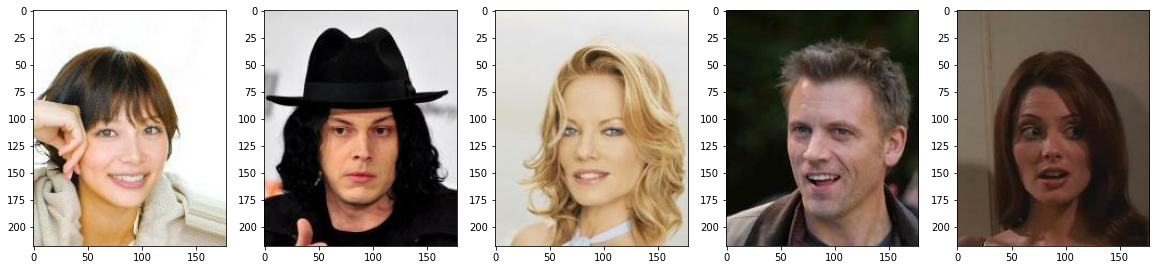

In [22]:
fig, ax = plt.subplots(ncols=5, figsize=(20,20))
for i in range(5): 
    sample = data_iterator.next()
    ax[i].imshow(sample['image'])

###Our images' values are between 0 & 255. We want to scale them to 0 & 1

In [23]:
def scale_images(data): 
    image = data['image']
    return image / 255

### We are going to pass our dataset through a pipeline:
- <b>map</b>
- <b>cache</b>: The first time the dataset is iterated over, its elements will be cached either in the specified file or in memory. Subsequent iterations will use the cached data.
- <b>shuffle</b>: This dataset fills a buffer with buffer_size elements, then randomly samples elements from this buffer, replacing the selected elements with new elements. For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required.
- <b>batch</b>
- <b>prefetch</b>: Most dataset input pipelines should end with a call to prefetch. This allows later elements to be prepared while the current element is being processed. This often improves latency and throughput, at the cost of using additional memory to store prefetched elements.

In [27]:
# Reload the dataset 
ds = tfds.load('celeb_a', split='train')
# Running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images) 
# Cache the dataset for that batch 
ds = ds.cache()
# Shuffle it up 
ds = ds.shuffle(162,770)
# Batch into 128 images per sample
ds = ds.batch(128)
# Reduces the likelihood of bottlenecking 
ds = ds.prefetch(64)

In [28]:
ds.as_numpy_iterator().next().shape

(128, 218, 178, 3)

#Build The Generator:

In [29]:
# These will be used for both the generator and the descriminator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

###We want the output image to be 218 X 173 X 3 like our dataset
###We can calculate the output of the Conv2D function as follows:
[(W−K+2P)/S]+1.

- W is the input volume - in your case 128
- K is the Kernel size - in your case 5
- P is the padding - in your case 0 i believe
- S is the stride - which you have not provided.

In [152]:
def build_generator(): 
    model = Sequential()
    
    # We are going to generate based on 128 random values
    # Takes in random values and reshapes it to 14x11x128. We are giving the 128 random values (array) some spatial area to output an image
    # Beginnings of a generated image
    model.add(Dense(14*11*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((14,11,128)))
    
    # Upsampling block 1 
    model.add(UpSampling2D()) # This gets us to 14X11X128
    model.add(Conv2D(filters = 128, kernel_size = 5, strides = 1, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Upsampling block 2 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Upsampling block 3 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Upsampling block 4
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Sampling block
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size = 5, strides = 2, padding='valid'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Conv layer to get to one channel
    model.add(Conv2D(3, 4, padding='same', activation='sigmoid'))
    
    return model

In [153]:
generator = build_generator()

In [154]:
generator.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 19712)             2542848   
                                                                 
 leaky_re_lu_236 (LeakyReLU)  (None, 19712)            0         
                                                                 
 reshape_41 (Reshape)        (None, 14, 11, 128)       0         
                                                                 
 up_sampling2d_191 (UpSampli  (None, 28, 22, 128)      0         
 ng2D)                                                           
                                                                 
 conv2d_199 (Conv2D)         (None, 28, 22, 128)       409728    
                                                                 
 leaky_re_lu_237 (LeakyReLU)  (None, 28, 22, 128)      0         
                                                     

We got an output of 222X174X3 which is almost like 218X178X3